In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import tensor
import random
import unicodedata, string, glob, os
import matplotlib.pyplot as plt

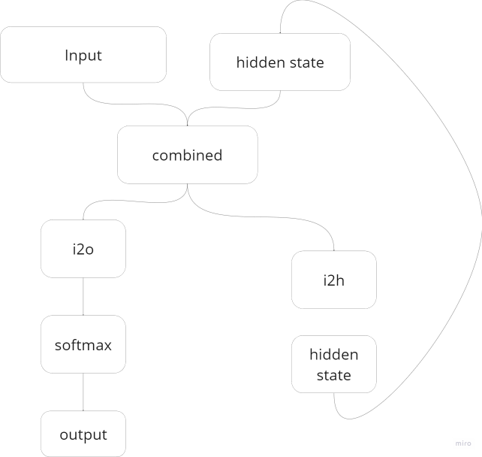

### A. Data preparation
- [x] Create alphabet dictionary (which will include some special characters like .,;')
- [x] Load ***.txt*** data into Python variables
    - [x] while loading - convert to ascii format: For example: ex ä ->a
- [x] Convert words into numbers by stacking one-hot encoding for each alphabets
- [x] Create input and output tensors

In [2]:
string.ascii_letters

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

##### A1. Create Alphabet Dictionary

In [3]:
all_letters = string.ascii_letters + ".,;''"
print(all_letters)
print(len(all_letters))

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,;''
57


##### A2. Load .txt data into Python variables
- [x] read the .txt files and get the data from txt into python dictionary so that we can use the data for computation

In [4]:
def findFiles(path):
    return glob.glob(path)

In [5]:
path = 'data/names/*.txt' 
findFiles(path)

['data/names\\Arabic.txt',
 'data/names\\Chinese.txt',
 'data/names\\Czech.txt',
 'data/names\\Dutch.txt',
 'data/names\\English.txt',
 'data/names\\French.txt',
 'data/names\\German.txt',
 'data/names\\Greek.txt',
 'data/names\\Irish.txt',
 'data/names\\Italian.txt',
 'data/names\\Japanese.txt',
 'data/names\\Korean.txt',
 'data/names\\Polish.txt',
 'data/names\\Portuguese.txt',
 'data/names\\Russian.txt',
 'data/names\\Scottish.txt',
 'data/names\\Spanish.txt',
 'data/names\\Vietnamese.txt']

In [6]:
# before we get all names of every language into a dictionary, we should have all characters in ascii format 
# For example: ex ä ->a

def unicode_to_ascii(name):
    return "".join(c for c in unicodedata.normalize('NFD',name)
                  if unicodedata.category(c)!='Mn'
                  and c in all_letters)

In [7]:
# check
name = 'Snehä'
unicode_to_ascii(name)

'Sneha'

In [8]:
def get_list_of_words(path):
    all_categories = []; category_lines = {}
    for fname in findFiles(path):
        list_of_words = open(fname, encoding = 'utf-8').read().strip().split('\n') # experiment with each -> .read().strip().split('\n')
        language = fname.split('\\')[-1].split('.')[0]
        
        #### convert to ascii #####
        list_of_words_ascii = []
        for word in list_of_words:
            list_of_words_ascii.append(unicode_to_ascii(word))
        ########################
        all_categories.append(language)
        category_lines[language] = list_of_words_ascii # use updated list of words in ascii format
        
    return all_categories, category_lines

In [9]:
all_categories, category_lines = get_list_of_words(path)

In [10]:
len(all_categories), all_categories

(18,
 ['Arabic',
  'Chinese',
  'Czech',
  'Dutch',
  'English',
  'French',
  'German',
  'Greek',
  'Irish',
  'Italian',
  'Japanese',
  'Korean',
  'Polish',
  'Portuguese',
  'Russian',
  'Scottish',
  'Spanish',
  'Vietnamese'])

In [11]:
# # check
# category_lines.keys(), category_lines['Chinese']

##### A3. Convert word into matrices/ tensors by stacking one-hot embedding of alphabets

In [12]:
name = 'cab'
print('all_letters: ', all_letters)
print('Index of c = ', all_letters.find('c'))

def alphabet_to_tensor(alphabet):
    one_hot = torch.zeros(1,len(all_letters))
    idx = all_letters.find(alphabet)
    one_hot[0][idx]=1
    return one_hot
    
alphabet_to_tensor('c')

all_letters:  abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,;''
Index of c =  2


tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [13]:
def name_to_tensor(name):
    return torch.stack([alphabet_to_tensor(alphabet) for alphabet in name])

In [14]:
name_to_tensor('cab')

tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])

##### A4. Create input and output tensors

In [15]:
def load_datapoint():
    ''' randomly select a language and then randomly select a word in it. 
    Return the output_tensor (one-hot) i.e. selected language and input_word in tensor format'''
    
    language_idx = random.sample(range(len(all_categories)),1)[0] # Sample 1 value and because it returns as list, index in it
    language = all_categories[language_idx]
    output_tensor = tensor([language_idx], dtype = torch.long) # needs to be integral and not (1,18) tensor
    
    
    language_words = category_lines[language]
    word_idx = random.sample(range(len(language_words)),1)[0]
    word = language_words[word_idx]
    word_tensor = name_to_tensor(word)
    
    return word, language, word_tensor, output_tensor

In [16]:
# check
for i in range(10):
    word, language, word_tensor, output_tensor = load_datapoint()
    print(word, language)
    

Klerk Dutch
Zdunowski Polish
Coma Czech
Porcher French
Adamoli Italian
Pokorny Polish
Tan Chinese
Ferro Portuguese
Munro Scottish
Yasuda Japanese


### B. Model development and training
- [x] Create RNN module
- [x] Create training function
- [x] Create evaulation function
- [ ] Monitor training and evaluation performance by tensorboard
- [x] Monitor training and evaluation performance (in Env if no tensorboard)

##### B1. Create RNN module
- Refer example for creating custom Pytorch `Class`: https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html
   - Step-1: In `def __init__(` : we define the architecture
   - Step-2: In `forward`: we define the flow of calculations
   
1. input_sz = len of features : Suppose (1,57) : 1 - one alphabet at a time, possibilities = 57 [One-hot vector]
1. hidden_sz = size of hidden state **(a hyperparameter)**
1. output_sz = number of classes : Total = 18

In [17]:
# # helpful to write before creating the RNN module
# input_sz = 57
# hidden_sz = 32
# output_sz = 18

In [18]:
class RNN(nn.Module):
    def __init__(self, input_sz, hidden_sz, output_sz):
        super(RNN, self).__init__()
        self.hidden_sz = hidden_sz
        self.i2h = nn.Linear(input_sz+hidden_sz, hidden_sz)
        self.i2o = nn.Linear(input_sz+hidden_sz, output_sz)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        
        combined = torch.cat((input, hidden),dim=1) # cat((1,57),(1,128), dim=1) -> (1, 185)
        hidden = self.i2h(combined) # update the hidden
        output = self.i2o(combined)
#         output = nn.LogSoftmax(output)## wont work. We need to define this in __init__ module
        output = self.softmax(output)
        return hidden, output
    
    def init_hidden(self):
        return torch.zeros((1, self.hidden_sz))


In [19]:
rnn = RNN(input_sz=57, hidden_sz=128, output_sz=18)
rnn

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

##### B2. Create training function

In [20]:
def label_to_language(pred):
    return all_categories[torch.argmax(pred)]

In [21]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(rnn.parameters(), lr=0.005)

In [22]:
def train(input_tensor, output_tensor):
    
    hidden = rnn.init_hidden()
    output_tensor = output_tensor.long()
    
    for i in range(input_tensor.size()[0]):
        hidden, m_output = rnn(input_tensor[i], hidden)
        
    loss = criterion(m_output,output_tensor) # loss calculated at the end. why?
        
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item(), m_output

In [23]:
itrs = 100000
plot_steps = 5000

train_losses = []
train_loss = 0
counter=0
for itr in range(itrs):
    
    word, language, input_tensor, output_tensor = load_datapoint()
    error, pred  = train(input_tensor, output_tensor)
    train_loss+=error
    
    if itr%plot_steps == 0:
        train_losses.append(train_loss/plot_steps)
        train_loss = 0
        counter+=1
        print(counter, ':', 'Actual: ', language, ', Pred: ', label_to_language(pred))
        print('')
        

1 : Actual:  Scottish , Pred:  Italian

2 : Actual:  Italian , Pred:  Japanese

3 : Actual:  Czech , Pred:  Portuguese

4 : Actual:  Portuguese , Pred:  Dutch

5 : Actual:  Czech , Pred:  Japanese

6 : Actual:  Japanese , Pred:  Korean

7 : Actual:  Czech , Pred:  Italian

8 : Actual:  Vietnamese , Pred:  Vietnamese

9 : Actual:  Arabic , Pred:  Arabic

10 : Actual:  German , Pred:  German

11 : Actual:  Chinese , Pred:  Chinese

12 : Actual:  Greek , Pred:  Greek

13 : Actual:  Portuguese , Pred:  Portuguese

14 : Actual:  Chinese , Pred:  Chinese

15 : Actual:  Czech , Pred:  English

16 : Actual:  Greek , Pred:  Greek

17 : Actual:  Czech , Pred:  Polish

18 : Actual:  French , Pred:  Arabic

19 : Actual:  Arabic , Pred:  Japanese

20 : Actual:  French , Pred:  French



In [24]:
c_counter = 0
t_counter = 0
rnn.eval()
all_preds = []
all_trues = []
with torch.no_grad():
    for k in range(len(all_categories)):
        label = torch.tensor([k], dtype = torch.long)
        lang = all_categories[k]
        lang_words = category_lines[lang]
        for word in lang_words:
            input_tensor = name_to_tensor(word)
            
            hidden = rnn.init_hidden()       
            for i in range(input_tensor.shape[0]):
                m_input = input_tensor[i]
                hidden, m_output = rnn(m_input, hidden)
            
            
            pred = torch.argmax(m_output).item()
            pred_lang = all_categories[pred]
            
            if pred_lang==lang:
                c_counter+=1
                
            t_counter+=1
            all_preds.append(pred)
            all_trues.append(label)
            
print("{}/{} correct".format(c_counter,t_counter))

11603/20074 correct


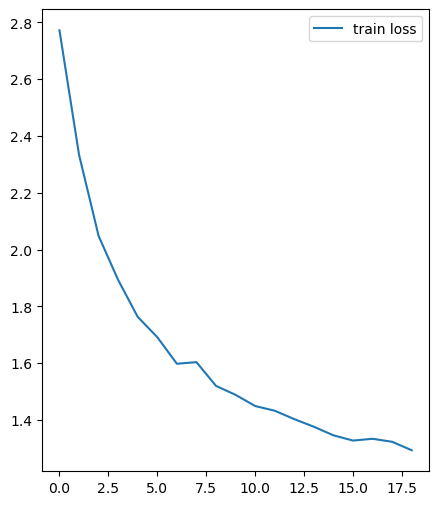

In [25]:
plt.figure(figsize=(5,6))
plt.plot(train_losses[1:], label = 'train loss')
plt.legend()

#### References

1.  Pytorch Link: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
1.  Video walkthrough: https://www.youtube.com/watch?v=WEV61GmmPrk&ab_channel=PatrickLoeber